YouTube per-CPU CGroup residency analysis
=======================
This is a run of experiments/run_youtube.py with the cgroups module enabled.
This notebook parses and plots the trace.html

In [1]:
#!/usr/bin/env python

import trappy
from trace import Trace
import itertools
import logging
import pandas as pd
import numpy as np
import os

from conf import LisaLogging
LisaLogging.setup()
logging.info('#### Setup FTrace')
# path_to_html = "/home/joelaf/repo/lisa-aosp/external/lisa/results/UiBench_default/trace.html"
# path_to_html = "/home/joelaf/repo/lisa-aosp/external/lisa/ipynb/residency/trace-residency.html"
path_to_html = "/home/joelaf/repo/lisa-aosp/external/lisa/results/YouTube_cgroups/trace.html"

2017-07-13 17:46:27,077 INFO    : root         : Using LISA logging configuration:
2017-07-13 17:46:27,078 INFO    : root         :   /home/joelaf/repo/lisa-aosp/external/lisa/logging.conf
2017-07-13 17:46:27,079 INFO    : root         : #### Setup FTrace


In [13]:
def plot_cgroups(df):
    # Bug in matplot lib causes plotting issues when residency is < 1
    df = df.apply(lambda x: x*10)
    plt.style.use('ggplot')
    colors = plt.rcParams['axes.color_cycle']
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12,30))

    for ax, col in zip(axes.flat, df.columns):
        ax.pie(df[col], labels=df.index, autopct='%.2f', colors=colors)
        ax.set(ylabel='', title=col, aspect='equal')

    axes[0, 0].legend(bbox_to_anchor=(0, 0.5))

    # fig.savefig('your_file.png') # Or whichever format you'd like
    plt.show()

tr = Trace(None, path_to_html,
           cgroup_info = { 
               'cgroups': ['foreground', 'background', 'system-background', 'top-app', 'rt'],
               'controller_ids': { 4: 'cpuset', 2: 'schedtune' }
           },
           events=[ 'sched_switch', 'cgroup_attach_task_devlib', 'cgroup_attach_task', 'sched_process_fork' ],
        normalize_time=False)

# tr.data_frame.trace_event('cgroup_attach_task_devlib')
# len(tr.data_frame.trace_event('cgroup_attach_task_devlib').groupby(level=0).filter(lambda x: len(x) > 1))

In [6]:
sdf = tr.data_frame.cpu_residencies('pid', 'sched_switch')

Total amount of time spent per Cgroup (schedtune)
===========================
(NaN is the idle task)

In [7]:
cdf = tr.data_frame.cpu_residencies('schedtune', 'sched_switch_cgroup')
cdf

,cpu_0,cpu_1,cpu_2,cpu_3,cpu_4,cpu_5,cpu_6,cpu_7,total
schedtune,,,,,,,,,
background,0.146127,0.092972,0.032810,0.008519,0.000000,0.000000,0.000000,0.196868,0.477296
foreground,2.657082,2.504777,2.170986,1.251793,0.599165,0.238603,0.443695,0.449116,10.315217
root,6.714916,2.914503,1.242770,0.758505,0.455794,0.224448,2.288803,0.828315,15.428054
top-app,0.481431,0.183362,0.117254,0.039979,3.956953,2.620467,1.283939,0.323175,9.006560
NaN,22.267126,26.600627,28.697950,30.170754,27.248223,29.178249,28.235624,30.500863,222.899416


Plot per-CPU breakdown without considering idle time
------------------------------------------------------------

Populating the interactive namespace from numpy and matplotlib


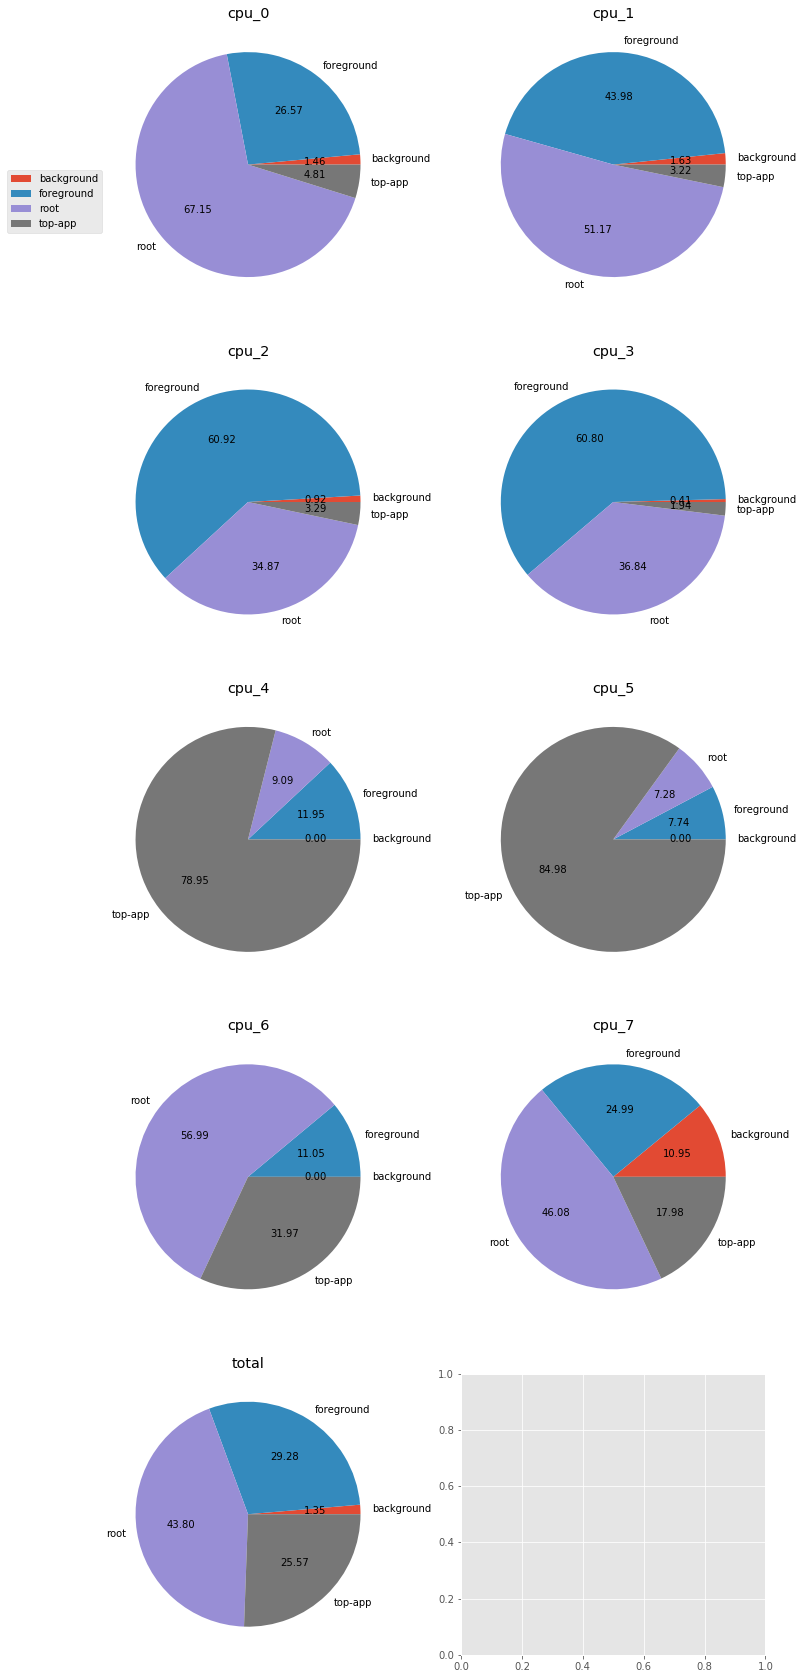

In [14]:
%pylab inline
# Drop NaN
ncdf = cdf[pd.isnull(cdf.index) != True]
plot_cgroups(ncdf)

Plot per-CPU breakdown WITH considering idle time (yellow slice)
------------------------------------------------------------

Populating the interactive namespace from numpy and matplotlib


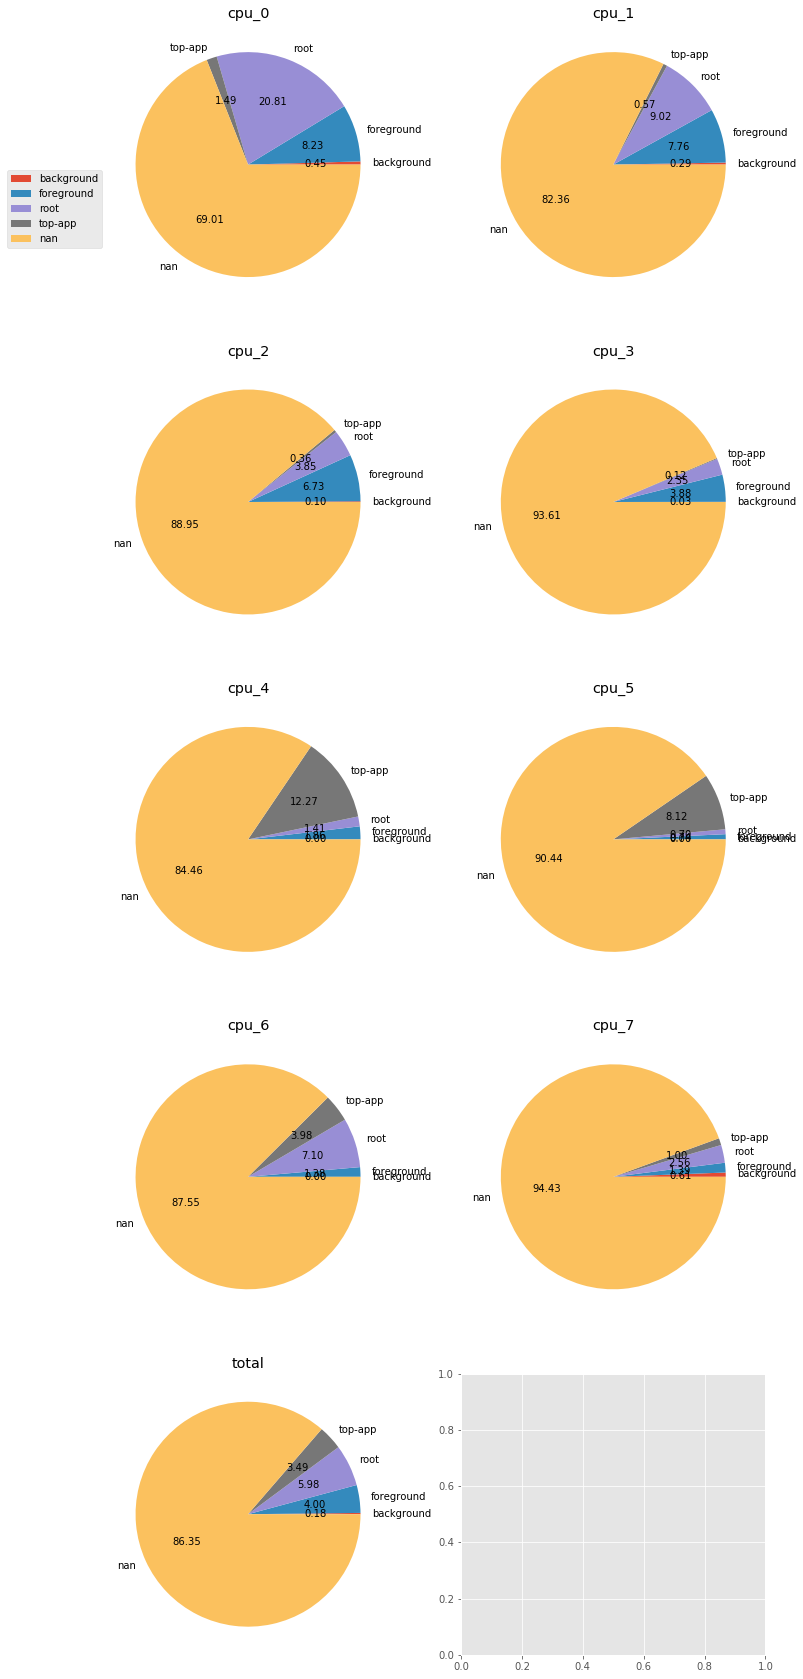

In [15]:
%pylab inline
plot_cgroups(cdf)